In [24]:
from newsapi import NewsApiClient
import pandas as pd

# Init
newsapi = NewsApiClient(api_key='ff4373852c2343a98303951439854f8c')

# /v2/top-headlines
top_headlines = newsapi.get_top_headlines(
                                          category='general',
                                          language='en',
                                          page_size=90,
                                          page=1
                                        )

# source = https://newsapi.org/docs/client-libraries/python
articles = top_headlines.get('articles', [])

    # Create a DataFrame with specific columns
df = pd.DataFrame(articles, columns=['source','title','publishedAt','author','url'])


# Data Cleaning
df['source'] = df['source'].apply(lambda x: x['name'] if pd.notna(x) and 'name' in x else None)


df


,source,title,publishedAt,author,url
0,CBS Sports,Kliff Kingsbury leading candidate to be Comman...,2024-02-03T20:07:00Z,,https://www.cbssports.com/nfl/news/raiders-oc-...
1,Variety,Alyssa Milano Says ‘I’m Sad’ for ‘Charmed’ Fan...,2024-02-03T19:19:00Z,Diego Ramos Bechara,https://variety.com/2024/tv/news/alyssa-milano...
2,Fox News,Speaker Johnson reveals $17 billion Israel aid...,2024-02-03T19:05:00Z,Elizabeth Elkind,https://www.foxnews.com/politics/speaker-johns...
3,Associated Press,Sinn Fein's Michelle O’Neill makes history as ...,2024-02-03T18:59:00Z,BRIAN MELLEY,https://apnews.com/article/northern-ireland-go...
4,CNN,US launches strikes in Iraq and Syria as Israe...,2024-02-03T18:34:00Z,"By Chris Lau, Nadeen Ebrahim and <a href=""/pro...",https://www.cnn.com/middleeast/live-news/israe...
...,...,...,...,...,...
85,CBS News,Far-right convoy protesting migrant crisis nea...,2024-02-03T02:31:00Z,Jacob Rosen,https://www.cbsnews.com/news/far-right-convoy-...
86,Universe Today,Astronomers are Getting Really Good at Weighin...,2024-02-03T00:22:09Z,Matt Williams,https://www.universetoday.com/165509/astronome...
87,CNN,"Global cancer cases will jump 77% by 2050, WHO...",2024-02-02T23:17:09Z,"Katherine Dillinger, CNN",https://www.cnn.com/2024/02/02/health/who-canc...
88,PEOPLE,Asteroid the Size of a Football Stadium Just W...,2024-02-02T21:52:30Z,https://www.facebook.com/peoplemag,https://people.com/asteroid-the-size-of-a-foot...


## Getting full articles

In [25]:
from newspaper import Article, Config

def full_content(url):
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
    config = Config()
    config.browser_user_agent = user_agent
    page = Article(url, config=config)
    
    try:
        page.download()
        page.parse()
        return page.text
    except Exception as e:
        print(f"Error retrieving content from {url}: {e}")
        return 'couldnt retrieve'




df['content'] = df['url'].apply(full_content)
df['content'] = df['content'].str.replace('\n', ' ')

df


Error retrieving content from https://removed.com: Article `download()` failed with 436 Client Error: status code 436 for url: https://removed.com/ on URL https://removed.com
Error retrieving content from https://removed.com: Article `download()` failed with 436 Client Error: status code 436 for url: https://removed.com/ on URL https://removed.com
Error retrieving content from https://removed.com: Article `download()` failed with 436 Client Error: status code 436 for url: https://removed.com/ on URL https://removed.com
Error retrieving content from https://www.usatoday.com/story/tech/problemsolved/2024/02/03/how-to-retrieve-deleted-text-messages-iphone/72434715007/: Article `download()` failed with 403 Client Error: Unknown Error for url: https://eu.usatoday.com/story/tech/problemsolved/2024/02/03/how-to-retrieve-deleted-text-messages-iphone/72434715007/ on URL https://www.usatoday.com/story/tech/problemsolved/2024/02/03/how-to-retrieve-deleted-text-messages-iphone/72434715007/
Error r

,source,title,publishedAt,author,url,content
0,CBS Sports,Kliff Kingsbury leading candidate to be Comman...,2024-02-03T20:07:00Z,,https://www.cbssports.com/nfl/news/raiders-oc-...,While he was expected to be named the Las Vega...
1,Variety,Alyssa Milano Says ‘I’m Sad’ for ‘Charmed’ Fan...,2024-02-03T19:19:00Z,Diego Ramos Bechara,https://variety.com/2024/tv/news/alyssa-milano...,"Alyssa Milano, who played Phoebe in the hit WB..."
2,Fox News,Speaker Johnson reveals $17 billion Israel aid...,2024-02-03T19:05:00Z,Elizabeth Elkind,https://www.foxnews.com/politics/speaker-johns...,"Speaker Mike Johnson, R-La., is putting legisl..."
3,Associated Press,Sinn Fein's Michelle O’Neill makes history as ...,2024-02-03T18:59:00Z,BRIAN MELLEY,https://apnews.com/article/northern-ireland-go...,LONDON (AP) — An Irish nationalist made histor...
4,CNN,US launches strikes in Iraq and Syria as Israe...,2024-02-03T18:34:00Z,"By Chris Lau, Nadeen Ebrahim and <a href=""/pro...",https://www.cnn.com/middleeast/live-news/israe...,"Israel’s military has attacked more than 3,400..."
...,...,...,...,...,...,...
85,CBS News,Far-right convoy protesting migrant crisis nea...,2024-02-03T02:31:00Z,Jacob Rosen,https://www.cbsnews.com/news/far-right-convoy-...,A convoy started by far-right extremists is bo...
86,Universe Today,Astronomers are Getting Really Good at Weighin...,2024-02-03T00:22:09Z,Matt Williams,https://www.universetoday.com/165509/astronome...,"In the 1970s, astronomers deduced that the per..."
87,CNN,"Global cancer cases will jump 77% by 2050, WHO...",2024-02-02T23:17:09Z,"Katherine Dillinger, CNN",https://www.cnn.com/2024/02/02/health/who-canc...,CNN — Global cancer diagnoses will reach 35 m...
88,PEOPLE,Asteroid the Size of a Football Stadium Just W...,2024-02-02T21:52:30Z,https://www.facebook.com/peoplemag,https://people.com/asteroid-the-size-of-a-foot...,An asteroid the size of a football stadium whi...


In [26]:
df = df[df['content'] != 'couldnt retrieve']
df

,source,title,publishedAt,author,url,content
0,CBS Sports,Kliff Kingsbury leading candidate to be Comman...,2024-02-03T20:07:00Z,,https://www.cbssports.com/nfl/news/raiders-oc-...,While he was expected to be named the Las Vega...
1,Variety,Alyssa Milano Says ‘I’m Sad’ for ‘Charmed’ Fan...,2024-02-03T19:19:00Z,Diego Ramos Bechara,https://variety.com/2024/tv/news/alyssa-milano...,"Alyssa Milano, who played Phoebe in the hit WB..."
2,Fox News,Speaker Johnson reveals $17 billion Israel aid...,2024-02-03T19:05:00Z,Elizabeth Elkind,https://www.foxnews.com/politics/speaker-johns...,"Speaker Mike Johnson, R-La., is putting legisl..."
3,Associated Press,Sinn Fein's Michelle O’Neill makes history as ...,2024-02-03T18:59:00Z,BRIAN MELLEY,https://apnews.com/article/northern-ireland-go...,LONDON (AP) — An Irish nationalist made histor...
4,CNN,US launches strikes in Iraq and Syria as Israe...,2024-02-03T18:34:00Z,"By Chris Lau, Nadeen Ebrahim and <a href=""/pro...",https://www.cnn.com/middleeast/live-news/israe...,"Israel’s military has attacked more than 3,400..."
...,...,...,...,...,...,...
84,Livemint,8 subtle signs of menopause women tend to over...,2024-02-03T02:53:29Z,None,https://lifestyle.livemint.com/health/wellness...,8 subtle signs of menopause women tend to over...
85,CBS News,Far-right convoy protesting migrant crisis nea...,2024-02-03T02:31:00Z,Jacob Rosen,https://www.cbsnews.com/news/far-right-convoy-...,A convoy started by far-right extremists is bo...
86,Universe Today,Astronomers are Getting Really Good at Weighin...,2024-02-03T00:22:09Z,Matt Williams,https://www.universetoday.com/165509/astronome...,"In the 1970s, astronomers deduced that the per..."
87,CNN,"Global cancer cases will jump 77% by 2050, WHO...",2024-02-02T23:17:09Z,"Katherine Dillinger, CNN",https://www.cnn.com/2024/02/02/health/who-canc...,CNN — Global cancer diagnoses will reach 35 m...


## Word Count without stopwords

In [27]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download the stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Function to count words without stopwords
def count_words_without_stopwords(text):
    # Check if the value is a string or bytes-like object
    if isinstance(text, (str, bytes)):
        # Tokenize the text
        words = nltk.word_tokenize(str(text))
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in words if word.lower() not in stop_words]
        
        # Return the count of non-stopwords
        return len(filtered_words)
    else:
        # If the value is not a string or bytes-like, return 0
        return 0
# Apply the function to the 'Text' column and create a new column 'WordCount'
df['WordCount'] = df['content'].apply(count_words_without_stopwords)
df


[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipykernel_681/2105429243.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WordCount'] = df['content'].apply(count_words_without_stopwords)


,source,title,publishedAt,author,url,content,WordCount
0,CBS Sports,Kliff Kingsbury leading candidate to be Comman...,2024-02-03T20:07:00Z,,https://www.cbssports.com/nfl/news/raiders-oc-...,While he was expected to be named the Las Vega...,366
1,Variety,Alyssa Milano Says ‘I’m Sad’ for ‘Charmed’ Fan...,2024-02-03T19:19:00Z,Diego Ramos Bechara,https://variety.com/2024/tv/news/alyssa-milano...,"Alyssa Milano, who played Phoebe in the hit WB...",436
2,Fox News,Speaker Johnson reveals $17 billion Israel aid...,2024-02-03T19:05:00Z,Elizabeth Elkind,https://www.foxnews.com/politics/speaker-johns...,"Speaker Mike Johnson, R-La., is putting legisl...",402
3,Associated Press,Sinn Fein's Michelle O’Neill makes history as ...,2024-02-03T18:59:00Z,BRIAN MELLEY,https://apnews.com/article/northern-ireland-go...,LONDON (AP) — An Irish nationalist made histor...,880
4,CNN,US launches strikes in Iraq and Syria as Israe...,2024-02-03T18:34:00Z,"By Chris Lau, Nadeen Ebrahim and <a href=""/pro...",https://www.cnn.com/middleeast/live-news/israe...,"Israel’s military has attacked more than 3,400...",179
...,...,...,...,...,...,...,...
84,Livemint,8 subtle signs of menopause women tend to over...,2024-02-03T02:53:29Z,None,https://lifestyle.livemint.com/health/wellness...,8 subtle signs of menopause women tend to over...,354
85,CBS News,Far-right convoy protesting migrant crisis nea...,2024-02-03T02:31:00Z,Jacob Rosen,https://www.cbsnews.com/news/far-right-convoy-...,A convoy started by far-right extremists is bo...,669
86,Universe Today,Astronomers are Getting Really Good at Weighin...,2024-02-03T00:22:09Z,Matt Williams,https://www.universetoday.com/165509/astronome...,"In the 1970s, astronomers deduced that the per...",580
87,CNN,"Global cancer cases will jump 77% by 2050, WHO...",2024-02-02T23:17:09Z,"Katherine Dillinger, CNN",https://www.cnn.com/2024/02/02/health/who-canc...,CNN — Global cancer diagnoses will reach 35 m...,489


In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sid = SentimentIntensityAnalyzer()


# Function to get sentiment scores and label
def get_sentiment(row):
    sentiment_scores = sid.polarity_scores(row)
    compound_score = sentiment_scores['compound']

    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment, compound_score

# Apply sentiment analysis to each row of the DataFrame
df[['Sentiment', 'Compound_Score']] = df['content'].apply(lambda x: pd.Series(get_sentiment(x)))
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gitpod/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/tmp/ipykernel_681/2425123425.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Sentiment', 'Compound_Score']] = df['content'].apply(lambda x: pd.Series(get_sentiment(x)))
/tmp/ipykernel_681/2425123425.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Sentiment', 'Compound_Score']] = df['content'].apply(lambda x: pd.Series(get_sentiment(x)))


,source,title,publishedAt,author,url,content,WordCount,Sentiment,Compound_Score
0,CBS Sports,Kliff Kingsbury leading candidate to be Comman...,2024-02-03T20:07:00Z,,https://www.cbssports.com/nfl/news/raiders-oc-...,While he was expected to be named the Las Vega...,366,Negative,-0.8847
1,Variety,Alyssa Milano Says ‘I’m Sad’ for ‘Charmed’ Fan...,2024-02-03T19:19:00Z,Diego Ramos Bechara,https://variety.com/2024/tv/news/alyssa-milano...,"Alyssa Milano, who played Phoebe in the hit WB...",436,Negative,-0.4022
2,Fox News,Speaker Johnson reveals $17 billion Israel aid...,2024-02-03T19:05:00Z,Elizabeth Elkind,https://www.foxnews.com/politics/speaker-johns...,"Speaker Mike Johnson, R-La., is putting legisl...",402,Negative,-0.8759
3,Associated Press,Sinn Fein's Michelle O’Neill makes history as ...,2024-02-03T18:59:00Z,BRIAN MELLEY,https://apnews.com/article/northern-ireland-go...,LONDON (AP) — An Irish nationalist made histor...,880,Positive,0.9910
4,CNN,US launches strikes in Iraq and Syria as Israe...,2024-02-03T18:34:00Z,"By Chris Lau, Nadeen Ebrahim and <a href=""/pro...",https://www.cnn.com/middleeast/live-news/israe...,"Israel’s military has attacked more than 3,400...",179,Negative,-0.9775
...,...,...,...,...,...,...,...,...,...
84,Livemint,8 subtle signs of menopause women tend to over...,2024-02-03T02:53:29Z,None,https://lifestyle.livemint.com/health/wellness...,8 subtle signs of menopause women tend to over...,354,Positive,0.4588
85,CBS News,Far-right convoy protesting migrant crisis nea...,2024-02-03T02:31:00Z,Jacob Rosen,https://www.cbsnews.com/news/far-right-convoy-...,A convoy started by far-right extremists is bo...,669,Negative,-0.9337
86,Universe Today,Astronomers are Getting Really Good at Weighin...,2024-02-03T00:22:09Z,Matt Williams,https://www.universetoday.com/165509/astronome...,"In the 1970s, astronomers deduced that the per...",580,Positive,0.9857
87,CNN,"Global cancer cases will jump 77% by 2050, WHO...",2024-02-02T23:17:09Z,"Katherine Dillinger, CNN",https://www.cnn.com/2024/02/02/health/who-canc...,CNN — Global cancer diagnoses will reach 35 m...,489,Negative,-0.9992


## top keywords

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

def get_top_keywords(tokens, top_n=30):
    # Calculate word frequencies
    freq_dist = FreqDist(tokens)
    
    # Get the top N keywords
    top_keywords = freq_dist.most_common(top_n)
    
    return top_keywords

text_data_column = df['content']

# Convert the column values to a single text variable
text_data = ' '.join(text_data_column.astype(str).tolist())

# Preprocess the text
preprocessed_tokens = preprocess_text(text_data)

# Get the top keywords
top_keywords = get_top_keywords(preprocessed_tokens)

# Print or use the top keywords
top_keywords

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('said', 216),
 ('also', 173),
 ('new', 106),
 ('one', 95),
 ('like', 90),
 ('last', 89),
 ('cancer', 89),
 ('first', 88),
 ('two', 86),
 ('million', 84),
 ('years', 77),
 ('year', 70),
 ('people', 68),
 ('galaxy', 63),
 ('would', 61),
 ('game', 60),
 ('could', 59),
 ('get', 56),
 ('even', 55),
 ('2024', 55),
 ('time', 54),
 ('make', 53),
 ('according', 50),
 ('state', 50),
 ('black', 50),
 ('around', 49),
 ('former', 48),
 ('company', 46),
 ('court', 46),
 ('four', 45)]

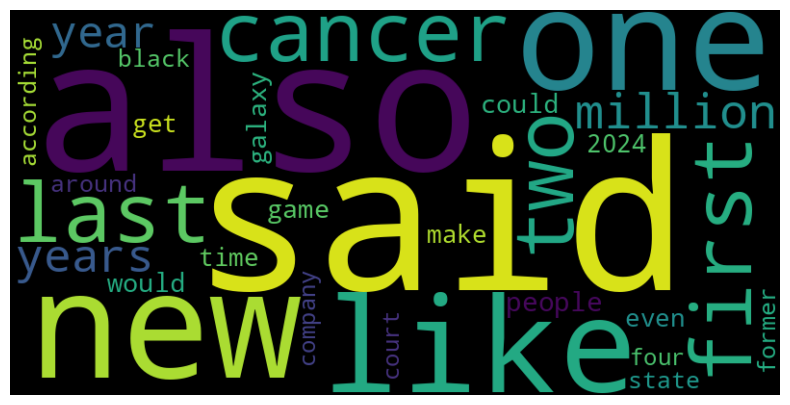

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Convert the list of tuples to a dictionary for WordCloud input
wordcloud_dict = dict(top_keywords)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wordcloud_dict)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis labels
plt.show()

## Topic modelling

In [37]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# text data from df column to list
text_data = df['content'].tolist()



def preprocess_text_list(text_list, remove_words=None, remove_single_alphabet=True):
    preprocessed_texts = []

    for text in text_list:
        # Tokenize the text
        tokens = word_tokenize(text.lower())

        # Remove stopwords, punctuation, and digits
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation and not token.isdigit()]

        # Remove specific words
        if remove_words:
            tokens = [token for token in tokens if token not in remove_words]

        # Remove 'n't' and other contractions
        tokens = [token for token in tokens if "’" not in token and "\'\'" not in token]

        # Remove singular alphabet characters
        if remove_single_alphabet:
            tokens = [token for token in tokens if len(token) > 1 or token.lower() == 'a' or token.lower() == 'i']

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        preprocessed_texts.append(tokens)

    return preprocessed_texts

preprocessed_texts_list = preprocess_text_list(text_data, remove_words=['``',"\'s"], remove_single_alphabet=True)

# Preprocess each document in the text data
#preprocessed_data = [preprocess_text(doc) for doc in text_data]

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(preprocessed_texts_list)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_texts_list]

# Build the LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
# Visualize the LDA model
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(lda_vis_data)
lda_model.print_topics()

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 

[(0,
  '0.009*"said" + 0.009*"cancer" + 0.005*"also" + 0.005*"carbon" + 0.004*"bjp" + 0.004*"year" + 0.003*"people" + 0.003*"say" + 0.003*"forest" + 0.003*"two"'),
 (1,
  '0.009*"galaxy" + 0.005*"year" + 0.005*"also" + 0.005*"stock" + 0.004*"company" + 0.004*"like" + 0.004*"million" + 0.004*"google" + 0.004*"said" + 0.004*"new"'),
 (2,
  '0.009*"court" + 0.008*"trump" + 0.006*"khan" + 0.005*"case" + 0.004*"said" + 0.004*"willis" + 0.004*"measles" + 0.004*"justice" + 0.003*"wade" + 0.003*"election"'),
 (3,
  '0.006*"said" + 0.004*"also" + 0.003*"like" + 0.003*"game" + 0.003*"year" + 0.003*"source" + 0.003*"new" + 0.003*"good" + 0.003*"ireland" + 0.003*"first"'),
 (4,
  '0.007*"season" + 0.006*"game" + 0.005*"also" + 0.005*"coach" + 0.004*"said" + 0.004*"year" + 0.004*"team" + 0.004*"million" + 0.004*"last" + 0.004*"nfl"')]